In [34]:
import re 
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sky\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sky\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Training set

In [35]:
training_set = pd.read_csv('train.csv')

In [36]:
training_set.head()

,textID,text,sentiment
0,cb774db0d1,"I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative
2,088c60f138,my boss is bullying me...,negative
3,9642c003ef,what interview! leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative


Cleaning

In [37]:
training_set.dropna(subset=['text'], inplace=True)

In [38]:
#use regular expression, re.sub() shows something that is not '\w', '\s', as 
#the symbol '^' is the negation.
training_set.text = training_set.text.apply(lambda x: re.sub(r'[^\w\s]', '', x) )

In [39]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english') #specify the language and get the stopwords in that language

#going through each of the text and removing any words that is in stopwords
training_set.text = training_set.text.apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))

In [40]:
training_set.text = training_set.text.apply(lambda x: re.sub(r'\(?http\S+', '', x))

In [41]:
#basically, normalise the words which words that are similar and have similar
#meaning will be treated as the same word.
from nltk.stem import PorterStemmer
porter_stemmer = PorterStemmer #Steming is choping off the words to the original word/common word

lemmatizer = nltk.WordNetLemmatizer() #Lemmatization will look at the words and try to find the base form of the words
training_set.text = training_set.text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]))

In [42]:
#Removing the remaining null text, after cleaning
training_set.dropna(subset=['text'], inplace=True)
trainint_set = training_set[training_set.text != '']

Data Exploration

In [43]:
training_set.head()

,textID,text,sentiment
0,cb774db0d1,Id responded going,neutral
1,549e992a42,Sooo SAD miss San Diego,negative
2,088c60f138,bos bullying,negative
3,9642c003ef,interview leave alone,negative
4,358bd9e861,Sons couldnt put release already bought,negative


In [44]:
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

word_str = training_set.iloc[:,:].text.str.cat(sep='. ')

In [45]:
import random
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(1, 20)

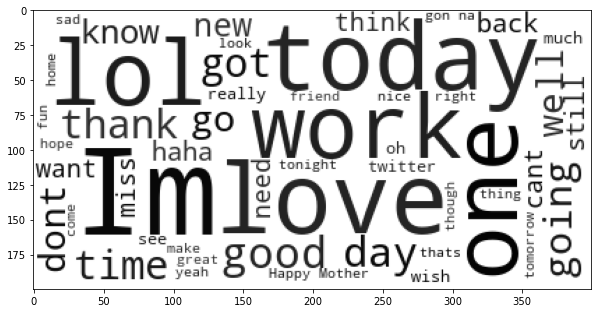

In [46]:
stp = STOPWORDS.copy()
wc = WordCloud(background_color="white", max_words=50,  stopwords=stp)
# generate word cloud
wc.generate(word_str)

plt.figure(figsize=(10,20))
plt.imshow(wc.recolor(color_func=grey_color_func, random_state=3))
plt.show()

Initialise data training

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn import metrics
import numpy as np

In [48]:
#CountVectorizer() function creates a feature matrix,
#transforming text into some training matrix which is used for machine learning
vectorizer = CountVectorizer()

In [49]:
training_set.dropna(subset=['text'], inplace=True)
train_X = vectorizer.fit_transform(training_set.text)
train_X

<27480x26934 sparse matrix of type '<class 'numpy.int64'>'
	with 193231 stored elements in Compressed Sparse Row format>

MultinomialNB model

In [50]:
nb = MultinomialNB()

#fitting the model, fitting train_X (x value) with training_set.sentiment (Y value)
#which is learning from the train set so when testing, we have to create the exact same feature matrix
#so the model can recognise it and generate predictions for it.
nb.fit(train_X, training_set.sentiment)

# use metrics.accuracy_score(y_true, y_pred) to see what's the accuracy is

MultinomialNB()

Load and Cleaning the testing dataset

In [51]:
testing_set = pd.read_csv('test.csv')

In [52]:

## 1. Droping null texts
testing_set.dropna(subset=['text'], inplace=True)
## 2. Removing punctuations and symbols
testing_set.text = testing_set.text.apply(lambda x: re.sub(r'[^\w\s]', '', x) )
## 3. Removing stopwords
testing_set.text = testing_set.text.apply(lambda x: ' '.join([word for word in nltk.word_tokenize(x) if word.lower() not in stopwords]))
## 4. Removing links
testing_set.text = testing_set.text.apply(lambda x: re.sub(r'\(?http\S+', '', x))
## 5. Lemmatization and Tokenizing
testing_set.text = testing_set.text.apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in nltk.word_tokenize(x)]))

In [53]:
testing_set.dropna(subset=['text'], inplace=True)
testing_set.head()

,textID,text
0,f87dea47db,Last session day
1,96d74cb729,Shanghai also really exciting precisely skyscr...
2,eee518ae67,Recession hit Veronique Branquinho quit compan...
3,01082688c6,happy bday
4,33987a8ee5,like


In [54]:
## vectorizing the test's texts 
test_X = vectorizer.transform(testing_set.text)

Prediction from the Trained Model

In [55]:
predicted = nb.predict(test_X)

In [56]:
prediction_data = pd.read_csv('test.csv')

In [57]:
prediction_data = prediction_data.assign(sentiment = predicted)

Output

In [58]:
kaggle_subm = prediction_data.drop('text', axis=1)

In [59]:
kaggle_subm.to_csv('Kaggle_subm.csv',index=False)